In [1]:
import os
import torch
import sys
sys.path.append('../../')

In [2]:
def set_num_threads(nt):
    "Get numpy (and others) to use `nt` threads"
    try: import mkl; mkl.set_num_threads(nt)
    except: pass
    torch.set_num_threads(nt)
    os.environ['IPC_ENABLE']='1'
    for o in ['OPENBLAS_NUM_THREADS','NUMEXPR_NUM_THREADS','OMP_NUM_THREADS','MKL_NUM_THREADS']:
        os.environ[o] = str(nt)

In [3]:
set_num_threads(8)

In [4]:
import libtiff
import imageio
import PIL
import numpy as np
import matplotlib.pyplot as plt
import fastai as fai
import fastai.vision as faiv
import fastai.callbacks as faic
import data.utils
import data.svd
from data import load

In [5]:
# Modify accordingly
path = faiv.Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/')

# dataset_name = 'real-world_SEM'

lr_name = f'training/trainsets/crappified/'
lr_path = path/f'{lr_name}'
# create list of crappified image filenames, sorted alphabetically
lr_files = sorted(list(lr_path.glob('*.tif')))

# hr_name = f'training/trainsets/hr/'
# hr_path = path/f'{hr_name}'
# hr_files = sorted(list(hr_path.glob('*.tif')))

print('Processing '+str(len(lr_files))+' files...')

Processing 99997 files...


In [6]:
# Set size for visualizations
fig_size = plt.rcParams["figure.figsize"]  # Get current size
print("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 30
fig_size[1] = 24
plt.rcParams["figure.figsize"] = fig_size
print("Updated size:", fig_size)

Current size: [6.0, 4.0]
Updated size: [30, 24]


In [7]:
bs = 8  # batch size
size = 512  # image size
lr_dir = f'training/trainsets/crappified/'  # input images
hr_dir = f'training/trainsets/hr/'  # target images
model_path = path/f'models/'  # path to saved models

In [8]:
# Load dataset in a databunch object 
db = load.get_data(path, lr_dir, hr_dir, bs, in_sz=size, out_sz=size, max_zoom=1)

In [9]:
from model.metrics import psnr, ssim
metrics = [faiv.F.mse_loss, psnr, ssim]

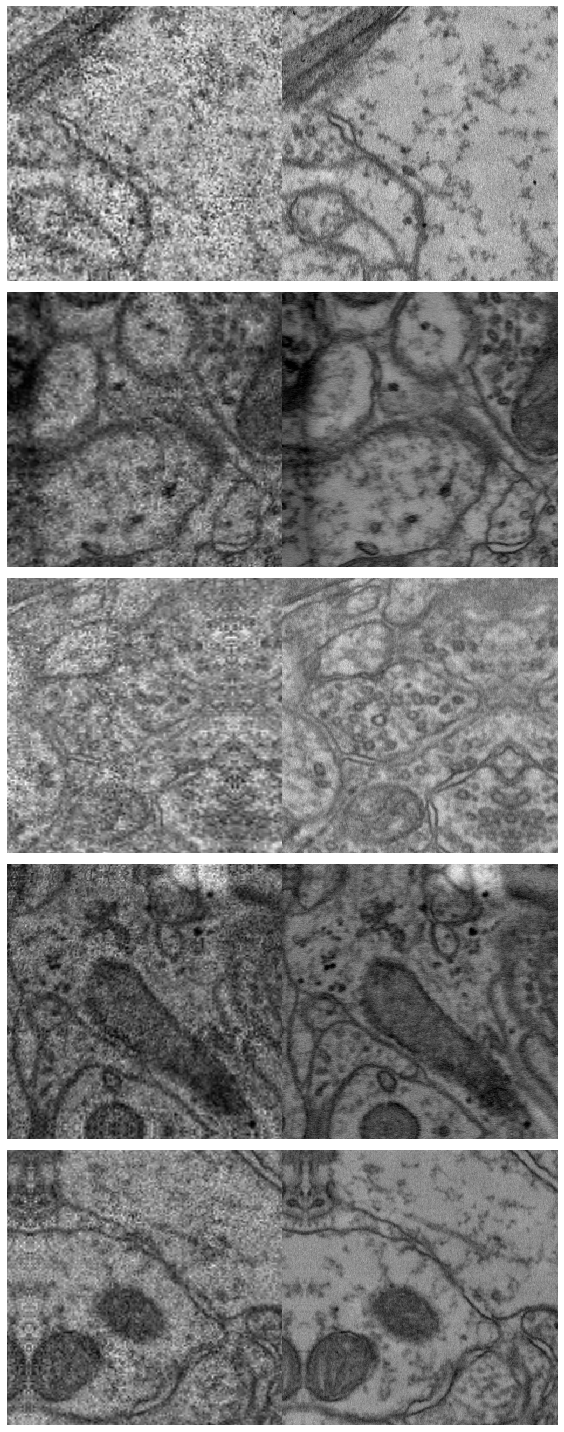

In [10]:
db.show_batch()

In [11]:
arch = faiv.models.resnet34
wd = 1e-3
learn = faiv.unet_learner(db, arch, wd=wd, 
                     #loss_func=feat_loss,
                     loss_func=faiv.F.mse_loss,
                     metrics=metrics, 
                     #callback_fns=LossMetrics, 
                     blur=True, norm_type=faiv.NormType.Weight, model_dir=model_path)
faiv.gc.collect()

21180

In [12]:
learn = learn.load('emsynth_005_unet.5')

In [13]:
learn.path = model_path

In [14]:
# export learner for inference
learn.export()

In [15]:
learn = faiv.load_learner(learn.path, test=faiv.ImageList.from_folder(path/lr_dir), tfm_y=False)

In [16]:
num = len(learn.data.test_ds)
print(num)

99997


In [17]:
def pssr_process(learner, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, input_itm in enumerate(learner.data.test_ds):
        input_img = input_itm[0]
        input_name = learner.data.test_ds.items[i]
        pred_itm = learner.predict(input_img)
        pred_name = input_name.stem.replace('lr', 'pssr') + '.tif'
        pred_itm[0].save(output_dir/pred_name)
        if i % 1000 == 0:
            print(f'Completed {i} PSSR Crappifications')
            print(f'Last file saved in {output_dir/pred_name}')
    print("PSSR Crappification Process Completed. Enjoy!")

In [ ]:
pssr_dir = faiv.Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/pssr')
pssr_process(learn, pssr_dir)

Completed 0 PSSR Crappifications
Last file saved in /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/pssr/EM_train_pssr_14625.tif
Completed 1000 PSSR Crappifications
Last file saved in /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/pssr/EM_train_pssr_47626.tif
Completed 2000 PSSR Crappifications
Last file saved in /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/pssr/EM_train_pssr_18048.tif
Completed 3000 PSSR Crappifications
Last file saved in /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/pssr/EM_train_pssr_81086.tif
Completed 4000 PSSR Crappifications
Last file saved in /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/pssr/EM_train_pssr_65794.tif


## Here We Validate A One-to-One Mapping between PSSR predictions and Original HR images through visualization

In [5]:
# Modify accordingly
path = faiv.Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/')

pssr_name = f'training/trainsets/pssr/'
pssr_path = path/f'{pssr_name}'
pssr_files = list(pssr_path.glob('*.tif'))

print('Processing '+str(len(pssr_files))+' files...')

Processing 7803 files...


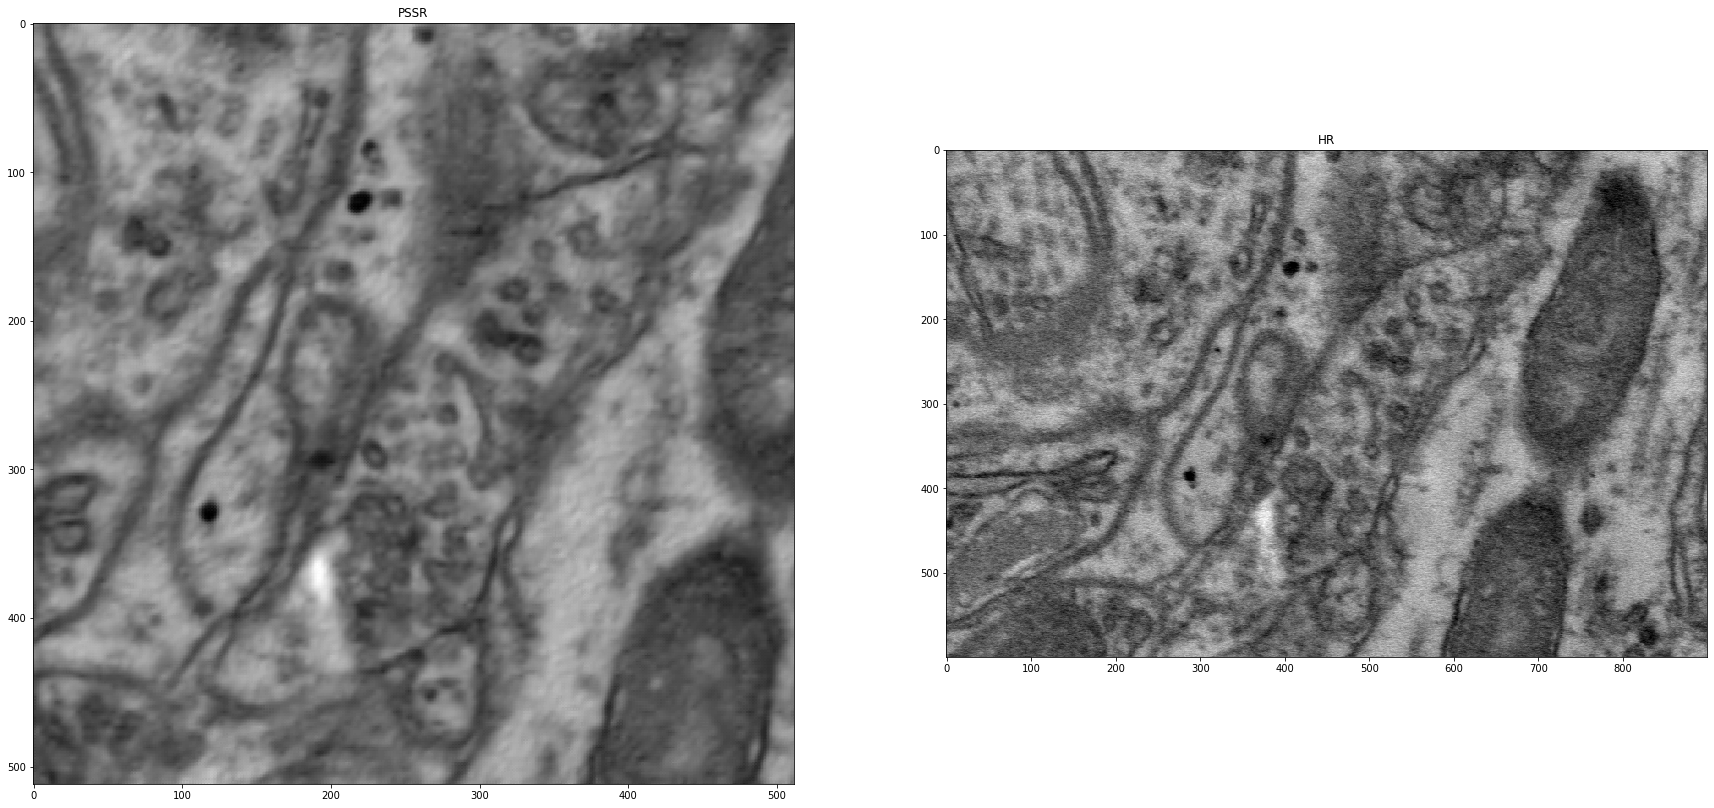

In [10]:
sn = 35 # image number
pssr_im = data.utils.load_img(pssr_files[sn]) # load image to tensor
hr_im = data.utils.load_img(str(pssr_files[sn]).replace("pssr", "hr"))
f, axarr = plt.subplots(1,2) # create visualizations
axarr[0].imshow(np.squeeze(pssr_im), cmap=plt.cm.gray) # visualize image tensor
axarr[0].set_title("PSSR")
axarr[1].imshow(np.squeeze(hr_im), cmap=plt.cm.gray) # visualize original image file
axarr[1].set_title("HR")
plt.show() # show visualization